# **<center>Home Credit Default Risk</center>**

**PySpark Introduction**
- Apache Spark is popular in big data due to in-memory computation and parallel processing.
- MLlib, built on Spark, is a scalable Machine Learning library with high-quality algorithms and speed.
- MLlib has APIs for Java, Python, and Scala, making it suitable for Data Analysts, Engineers, and Scientists.
- MLlib includes algorithms for classification, regression, clustering, collaborative filtering, and more.

**Problem Statement Introduction**
- The article discusses building an end-to-end machine learning model using MLlib in PySpark.
- The dataset used is from the Home Credit Default Risk competition on Kaggle.
- The objective is to determine if loan applicants can repay their loans based on collected data.
- It's a binary classification problem with an imbalanced target label: 0 (applicants who paid back loans) and 1 (applicants who didn't).
- The distribution ratio is approximately 0.91 (applicants who repaid) to 0.09 (applicants who didn't).

## **1. Data Ingestion and Spark session creation**
- Dataset Link: https://www.kaggle.com/c/home-credit-default-risk

In [1]:
from pyspark.sql import SparkSession
# initiate our session and read the main CSV file, then we print the #dataframe schema
spark = SparkSession.builder.appName('imbalanced_binary_classification').getOrCreate()
new_df = spark.read.csv("../Data/application_train.csv/application_train.csv", header=True, inferSchema=True)
new_df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

- printSchema() only shows us the column names and its data type. we are going to drop the SK_ID_CURR column, rename the “TARGET” column to “label” and see the distribution of our target variable:

## **2. Analysis of the Data**

In [2]:
# Sk_ID_Curr is the id column which we dont need it in the process #so we get rid of it. and we rename the name of our 
# target variable to "label"
drop_col = ['SK_ID_CURR']
new_df = new_df.select([column for column in new_df.columns if column not in drop_col])
new_df = new_df.withColumnRenamed('TARGET', 'label')
new_df.groupby('label').count().toPandas()

,label,count
0,1,24825
1,0,282686


- Dataset is highly imbalanced

307511


d:\Personal Files\Projects\Credit_Risk_Modelling_using_PySpark\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Personal Files\Projects\Credit_Risk_Modelling_using_PySpark\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label', ylabel='count'>

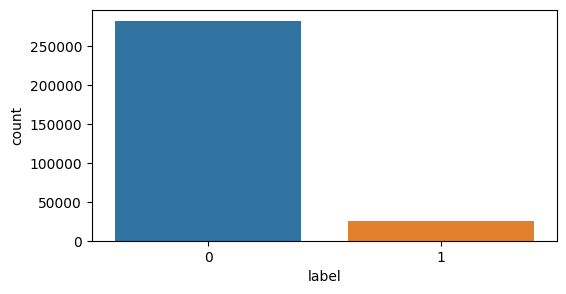

In [3]:
# let's have a look at the distribution of our target variable:
# to make it look better, we first convert our spark df to a Pandas
# Import the updated library
import pandas as pd
# Rest of your code
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df_pd = new_df.toPandas()
print(len(df_pd))
plt.figure(figsize=(6,3))
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)


**Data Wrangling can be summarized in the following points:**

1. Understanding Dataset Structure: Begin by gaining insights into the dataset's general structure.

2. Identifying Feature Types: Determine the count of Categorical and Numerical features within the dataset.

3. Handling Missing Values: Develop a function to extract crucial information regarding missing values in the dataset.

**Identifying Categorical & Numerical features**

In [4]:
# now let's see how many categorical and numerical features we have:
cat_cols = [item[0] for item in new_df.dtypes if item[1].startswith('string')] 
print(str(len(cat_cols)) + '  categorical features')
num_cols = [item[0] for item in new_df.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]
print(str(len(num_cols)) + '  numerical features')


16  categorical features
104  numerical features


**Identifying missing info**

In [5]:
# we use the below function to find more information about the #missing values
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    #count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
    #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
    #rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns
    
missings = info_missing_table(df_pd)
missings


Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


- There are 67 columns out of 121 that has missing values in them. and it doesn't show all of them in the image, but overall, most of these 67 columns have more than 50 percent missing values. so we are dealing with a lot of missing values. we are going to fill the numerical missing values with the average of each column and the categorical missing values with the most frequent category of each column. 

In [6]:
# so this function deals with the a spark dataframe directly to find more about the missing values
def count_missings(spark_df):
    null_counts = []        
    for col in spark_df.dtypes:    
        cname = col[0]     
        ctype = col[1]      
        nulls = spark_df.where( spark_df[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts

In [7]:
# counts =missings.index
# miss_counts = []
# for column, miss_count in zip(missings.index, missings['Missing Values']):
#     miss_counts.append((column, miss_count))

miss_counts = count_missings(new_df)
miss_counts


[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('NAME_TYPE_SUITE', 1292),
 ('OWN_CAR_AGE', 202929),
 ('OCCUPATION_TYPE', 96391),
 ('CNT_FAM_MEMBERS', 2),
 ('EXT_SOURCE_1', 173378),
 ('EXT_SOURCE_2', 660),
 ('EXT_SOURCE_3', 60965),
 ('APARTMENTS_AVG', 156061),
 ('BASEMENTAREA_AVG', 179943),
 ('YEARS_BEGINEXPLUATATION_AVG', 150007),
 ('YEARS_BUILD_AVG', 204488),
 ('COMMONAREA_AVG', 214865),
 ('ELEVATORS_AVG', 163891),
 ('ENTRANCES_AVG', 154828),
 ('FLOORSMAX_AVG', 153020),
 ('FLOORSMIN_AVG', 208642),
 ('LANDAREA_AVG', 182590),
 ('LIVINGAPARTMENTS_AVG', 210199),
 ('LIVINGAREA_AVG', 154350),
 ('NONLIVINGAPARTMENTS_AVG', 213514),
 ('NONLIVINGAREA_AVG', 169682),
 ('APARTMENTS_MODE', 156061),
 ('BASEMENTAREA_MODE', 179943),
 ('YEARS_BEGINEXPLUATATION_MODE', 150007),
 ('YEARS_BUILD_MODE', 204488),
 ('COMMONAREA_MODE', 214865),
 ('ELEVATORS_MODE', 163891),
 ('ENTRANCES_MODE', 154828),
 ('FLOORSMAX_MODE', 153020),
 ('FLOORSMIN_MODE', 208642),
 ('LANDAREA_MODE', 182590),
 ('LIVINGAPARTMENTS_MO

## **3. Data Pre-processing**
**Separate categorical and numerical columns with missing values**

In [8]:
# here we seperate missing columns in our new_df based on #categorical and numerical types
list_cols_miss=[x[0] for x in miss_counts]
list_cols_miss
df_miss= new_df.select(*list_cols_miss)
# categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("cateogrical columns_miss:", catcolums_miss)
### numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numerical columns_miss:", numcolumns_miss)

cateogrical columns_miss: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
numerical columns_miss: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRA

**Fill the missing values**

In [9]:
# now that we have seperated the columns based on categorical and #numerical types, we will fill the missing categiracl 
# values with the most frequent category
from pyspark.sql.functions import rank,sum,col
df_Nomiss=new_df.na.drop()
for x in catcolums_miss:                  
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode) #print name of columns and it's most categories 
    new_df = new_df.na.fill({x:mode})
# and we fill the missing numerical values with the average of each #column
from pyspark.sql.functions import mean, round
for i in numcolumns_miss:
    meanvalue = new_df.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    new_df=new_df.na.fill({i:meanvalue})

NAME_TYPE_SUITE Unaccompanied
OCCUPATION_TYPE Laborers
FONDKAPREMONT_MODE reg oper account
HOUSETYPE_MODE block of flats
WALLSMATERIAL_MODE Panel
EMERGENCYSTATE_MODE No
AMT_ANNUITY 27109.0
AMT_GOODS_PRICE 538396.0
OWN_CAR_AGE 12.0
CNT_FAM_MEMBERS 2.0
EXT_SOURCE_1 1.0
EXT_SOURCE_2 1.0
EXT_SOURCE_3 1.0
APARTMENTS_AVG 0.0
BASEMENTAREA_AVG 0.0
YEARS_BEGINEXPLUATATION_AVG 1.0
YEARS_BUILD_AVG 1.0
COMMONAREA_AVG 0.0
ELEVATORS_AVG 0.0
ENTRANCES_AVG 0.0
FLOORSMAX_AVG 0.0
FLOORSMIN_AVG 0.0
LANDAREA_AVG 0.0
LIVINGAPARTMENTS_AVG 0.0
LIVINGAREA_AVG 0.0
NONLIVINGAPARTMENTS_AVG 0.0
NONLIVINGAREA_AVG 0.0
APARTMENTS_MODE 0.0
BASEMENTAREA_MODE 0.0
YEARS_BEGINEXPLUATATION_MODE 1.0
YEARS_BUILD_MODE 1.0
COMMONAREA_MODE 0.0
ELEVATORS_MODE 0.0
ENTRANCES_MODE 0.0
FLOORSMAX_MODE 0.0
FLOORSMIN_MODE 0.0
LANDAREA_MODE 0.0
LIVINGAPARTMENTS_MODE 0.0
LIVINGAREA_MODE 0.0
NONLIVINGAPARTMENTS_MODE 0.0
NONLIVINGAREA_MODE 0.0
APARTMENTS_MEDI 0.0
BASEMENTAREA_MEDI 0.0
YEARS_BEGINEXPLUATATION_MEDI 1.0
YEARS_BUILD_MEDI 1.0


- The dataset no longer contains missing values.

**Handling Imbalanced Classess**

- The next step is addressing the issue of imbalanced classes.
- Various methods can be used to mitigate this problem.
- One approach involves under-sampling the majority class or over-sampling the minority class to achieve a more balanced outcome.
- Another approach is assigning weights to each class to penalize the majority class with lower weights and boost the minority class with higher weights.
- To implement this, a new column called "weights" is created in the dataset.
- The weights are assigned based on the inverse ratio of each class.

In [10]:
# adding the new column weights and fill it with ratios
from pyspark.sql.functions import when
ratio = 0.91
def weight_balance(labels):
    return when(labels == 1, ratio).otherwise(1*(1-ratio))
new_df = new_df.withColumn('weights', weight_balance(col('label')))

In [11]:
new_df.show(5)

+-----+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----

**Feature Engineering**
- The next step in the process is Feature Engineering.
- pySpark simplifies feature extraction, making it easier.
- The steps involved in feature extraction are as follows:
  1. Apply StringIndexer() to assign indices to each category in our categorical columns.
  2. Use OneHotEncoderEstimator() to convert categorical columns into one-hot encoded vectors.
  3. Apply VectorAssembler() to create a feature vector that combines all categorical and numerical features, referred to as "features."

In [12]:
# We use the OneHotEncoderEstimator from MLlib in Spark to convert each categorical feature into one-hot vectors.
# Next, we use VectorAssembler to combine the resulting one-hot vectors and the rest of the numerical features into a single vector column.
# We append every step of the process in a stages array.

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []

for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


1. We will now create a pipeline.
2. This pipeline will perform a sequence of transformations.
3. The purpose is to apply all these transformations at once.
4. This approach simplifies the process of applying multiple transformations in a sequence.

In [13]:
# we use a pipeline to apply all the stages of transformation
from pyspark.ml import Pipeline
cols = new_df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(new_df)
new_df = pipelineModel.transform(new_df)
selectedCols = ['features']+cols
new_df = new_df.select(selectedCols)
pd.DataFrame(new_df.take(5), columns=new_df.columns)

,features,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,weights
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.91
1,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
2,"(0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09
3,"(1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.09
4,"(1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.09


## **4. Model Building**
**Training and Hyper-parameter Tuning**
- Split the dataset into training and testing sets for training.
- Begin training with Logistic Regression.
- Choose Logistic Regression for its performance in binary classification problems.

**Train-Test Split**

In [14]:
# split the data into trainign and testin sets
train, test = new_df.randomSplit([0.80, 0.20], seed = 42)
print(train.count())
print(test.count())

246240
61271


**Logistics Regression**

In [15]:
# first we check how LogisticRegression perform 
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

**Gradient Boosting Trees (GBT)**

In [16]:
# next we checkout gradient boosting trees
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=15)
GBT_Model = gbt.fit(train)

- Achieved a significantly improved result of 0.732 using GBT.


**Hyperparameter Tuning - Gradient Boosting Trees (GBT)**
- Final strategy includes hyper-parameter tuning through grid search.
- Planning to follow up with cross-validation to further enhance GBT performance.

In [19]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator  # Import BinaryClassificationEvaluator

paramGrid = (ParamGridBuilder().addGrid(gbt.maxDepth, [2, 4, 6]).addGrid(gbt.maxBins, [20, 30]).addGrid(gbt.maxIter, [10, 15]).build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator = BinaryClassificationEvaluator(), numFolds=5)
# Run cross validations.
cvModel = cv.fit(train)

- The result showed a slight improvement.
- There is room for further enhancement by experimenting with hyper-parameter tuning.

## **5. Model Evaluation**
1. We will create an ROC curve for the training data.
2. The purpose is to assess the performance of Logistic Regression.
3. We will utilize the Area Under the ROC Curve (AUC-ROC).
4. AUC-ROC is a common metric for evaluating binary classification models.

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()

predictions_LR = LR_model.transform(test)
print("Test_SET Logistic Regression (Area Under ROC): " + str(evaluator.evaluate(predictions_LR, {evaluator.metricName: "areaUnderROC"})))

gbt_predictions = GBT_Model.transform(test)
print("Test_SET GBT (Area Under ROC): " + str(evaluator.evaluate(gbt_predictions, {evaluator.metricName: "areaUnderROC"})))

gbt_cv_predictions = cvModel.transform(test)
print("Test_SET GBT_Tuned (Area Under ROC): " + str(evaluator.evaluate(gbt_cv_predictions, {evaluator.metricName: "areaUnderROC"})))


Test_SET Logistic Regression (Area Under ROC): 0.7215699765501389
Test_SET GBT (Area Under ROC): 0.7298618196435773
Test_SET GBT_Tuned (Area Under ROC): 0.7321482798175072


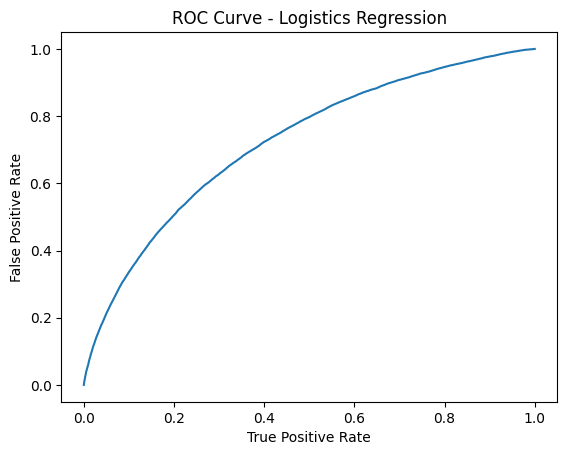

Training set ROC: 0.7229899807041205


In [24]:
#plotting the ROC Curve
trainingSummary = LR_model.summary
roc_LR = trainingSummary.roc.toPandas()
plt.plot(roc_LR['FPR'],roc_LR['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve - Logistics Regression')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

# **<center>THE END</center>**